# How to build a foundation of AI-based healthcare systems through language models?
## NLP Summit 2022 by Mehdi Bahrami

### Talk is available at: https://www.nlpsummit.org/how-to-build-a-foundation-of-ai-based-healthcare-systems-through-language-models/
### 4/5/2022

In [1]:
#import libraries 
import transformers 
import tensorflow as tf
import keras as k
import sys
import seaborn as sns
import numpy as np
from spacy import displacy
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
#check current versions
print(f"transormers:{transformers.__version__}")
print(f"tensorflow:{tf.__version__}")
print(f"keras:{k.__version__}")

transormers:4.16.2
tensorflow:2.7.0
keras:2.7.0


# Sample EHR

In [3]:
#Ref: https://medicalcodify.com/eh/webchart.cgi?f=layoutnouser&func=&module=&tabmodule=&name=RXDBmain&searchterm=CMS3&showresult=CMS347v2&showresulttype=Measure
corpus= ["Percentage of the following patients - all considered at high risk of cardiovascular events - who were prescribed or were on statin therapy during the measurement period: *Adults aged >= 21 years who were previously diagnosed with or currently have an active diagnosis of clinical atherosclerotic cardiovascular disease (ASCVD); OR *Adults aged >= 21 years who have ever had a fasting or direct low-density lipoprotein cholesterol (LDL-C) level >= 190 mg/dL or were previously diagnosed with or currently have an active diagnosis of familial or pure hypercholesterolemia; OR *Adults aged 40-75 years with a diagnosis of diabetes with a fasting or direct LDL-C level of 70-189 mg/dL"]

In [4]:
corpus #check the sample EHR record

['Percentage of the following patients - all considered at high risk of cardiovascular events - who were prescribed or were on statin therapy during the measurement period: *Adults aged >= 21 years who were previously diagnosed with or currently have an active diagnosis of clinical atherosclerotic cardiovascular disease (ASCVD); OR *Adults aged >= 21 years who have ever had a fasting or direct low-density lipoprotein cholesterol (LDL-C) level >= 190 mg/dL or were previously diagnosed with or currently have an active diagnosis of familial or pure hypercholesterolemia; OR *Adults aged 40-75 years with a diagnosis of diabetes with a fasting or direct LDL-C level of 70-189 mg/dL']

# Text Analysis

In [5]:
import spacy
try:
    nlp = spacy.load("en_core_web_lg", ) #load pre-trained model, more models? checkout: https://spacy.io/models/en
except:
    !{sys.executable} -m spacy download en_core_web_lg # you may need to download the pretrained model
    nlp = spacy.load("en_core_web_lg")

In [6]:
doc = nlp("The patient diagnosed with COVID-19")
tokens = [_ for _ in doc]
tokens #check the list of tokens

[The, patient, diagnosed, with, COVID-19]

In [7]:
lemmatizer = nlp.get_pipe("lemmatizer")

In [8]:
print([token.lemma_ for token in doc])

['the', 'patient', 'diagnose', 'with', 'covid-19']


In [9]:
# Analyze text and relations between tokens of given sentence
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

The the DET DT det Xxx True True
patient patient NOUN NN ROOT xxxx True False
diagnosed diagnose VERB VBN acl xxxx True False
with with ADP IN prep xxxx True True
COVID-19 covid-19 NOUN NN pobj XXXX-dd False False


In [10]:
from spacy import displacy
displacy.render(doc, style="dep") #viusalize the relationship among tokens 

In [11]:
# find similarity between a set of words
results=[]
docs =["heart disease", 
       "cardiovascular", 
       "diabetes", 
       "device"] # we should expect that we will have an irrelevant semantic similarity to this word
for doc in docs:
    results.append(nlp(doc))
similarities=np.zeros((len(docs),len(docs)))
for base in range(len(results)):
    for target in range(len(results)):
        similarities[base][target]=results[base].similarity(results[target])
similarities

array([[1.        , 0.65703055, 0.69451725, 0.2171583 ],
       [0.65703055, 1.        , 0.69552661, 0.1991938 ],
       [0.69451725, 0.69552661, 1.        , 0.18295031],
       [0.2171583 , 0.1991938 , 0.18295031, 1.        ]])

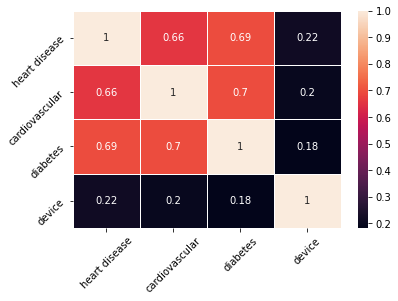

In [12]:
# let's visualize the output
fig, ax = plt.subplots()
ax = sns.heatmap(similarities, linewidth=0.5, annot=True)
ax.set_xticklabels(docs, rotation=45)
ax.set_yticklabels(docs, rotation=45)
plt.show()

# Word2Vec

In [13]:
# Use Gensim Word2Vec  
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
import gensim

In [14]:
#this is a simple model
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

In [15]:
#this is Glove; more detail can be found at: https://nlp.stanford.edu/projects/glove/
word_vectors = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

In [16]:
# let's load a pretrained model for medical documents
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database
#url: https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
word2vec = gensim.models.KeyedVectors.load_word2vec_format(
     'src/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      # limit=None, 
      limit=int(1_000_000) 
)

## Whats is a word that is similar to 'disease', 'cardiovascular' and it is not related to 'diabetes'?

We will use the pretrained `BioWordVec_PubMed_MIMICIII_d200` to answer this question

In [17]:
word2vec.most_similar(positive=['disease', 'cardiovascular'], negative=['diabetes'])

[('cardiovascular-disease', 0.7042478322982788),
 ('disease.1', 0.6750470995903015),
 ('cardiovasculary', 0.6509307622909546),
 ('diseaseand', 0.6506668925285339),
 ('cardiovasculature', 0.6493374109268188),
 ('extracardiovascular', 0.6385131478309631),
 ('cerebro-cardiovascular', 0.636828601360321),
 ('neuro-cardiovascular', 0.6364724040031433),
 ('diseas', 0.6313492059707642),
 ('cadiovascular', 0.6295813918113708)]

## What are similar words to 'cardiovascular'?

In [18]:
sims = word2vec.most_similar('cardiovascular', topn=10)
sims

[('cardiovasculary', 0.9357172846794128),
 ('cardiovascular-', 0.9062358736991882),
 ('noncardiovascular', 0.9051880836486816),
 ('non-cardiovascular', 0.9023175239562988),
 ('cardiovascularly', 0.8943461179733276),
 ('neuro-cardiovascular', 0.8922504782676697),
 ('cardiovascular-renal', 0.8921498656272888),
 ('cerebro/cardiovascular', 0.8904604315757751),
 ('neurocardiovascular', 0.8892894983291626),
 ('cardiovasculature', 0.8886768221855164)]

## What are similar words to 'diabetes'?

In [19]:
sims = word2vec.most_similar('diabetes', topn=10)
sims

[('mellitus', 0.943260908126831),
 ('2diabetes', 0.9345118403434753),
 ('1diabetes', 0.9249724745750427),
 ('diabetes-mellitus', 0.911189079284668),
 ('1-diabetes', 0.9087139368057251),
 ('prediabetes/diabetes', 0.889900267124176),
 ('help-diabetes', 0.8870837092399597),
 ('diabetes/prediabetes', 0.8870766758918762),
 ('pre-diabetes/diabetes', 0.883660078048706),
 ('2-diabetes', 0.8833818435668945)]

## Which word doesn't match to other words in `cardiovascular heart diabetes device`?

In [20]:
word2vec.doesnt_match("cardiovascular heart diabetes device".split())

'device'

## Which word doesn't match to other words in `cardiovascular heart diabetes HCM`?
### `HCM` is a heart disease

In [21]:
word2vec.doesnt_match("cardiovascular heart diabetes HCM".split())

'diabetes'

## Compare the distance vector representations between two words of `cardiovascular`, `diabetes` in Word2Vec

In [22]:
word_vectors.distance("cardiovascular", "diabetes")

0.24358290433883667

## Let's compare the distance vector representations between two words of `cardiovascular`, `heart` in Word2Vec
### It should be higher than previous words

In [23]:
word_vectors.distance("cardiovascular", "heart")

0.4669126272201538

## What is the vector (numeric) representation size for a word of `cardiovascular` in the pretrained model?

In [24]:
word_vectors['cardiovascular'].shape

(100,)

## What is the vector (numeric) representation for a word of `cardiovascular` in the pretrained model?

In [25]:
word_vectors['cardiovascular']

array([-0.063927 , -0.24056  , -0.4748   ,  0.26566  , -0.58629  ,
       -0.34764  ,  0.19974  , -0.21486  , -0.95679  ,  0.11892  ,
       -0.064613 ,  0.029716 ,  0.12213  , -0.42699  ,  0.53195  ,
        0.33944  , -0.50342  , -0.15205  , -0.010427 , -0.63419  ,
       -0.42881  , -0.88133  , -0.17609  ,  0.3787   , -0.57562  ,
        1.1164   ,  0.27586  , -0.89914  , -0.38188  , -0.082689 ,
        0.22638  , -0.11732  , -0.63669  ,  0.1358   , -0.11595  ,
        0.11031  , -0.15326  ,  1.2685   , -0.50569  ,  0.50787  ,
        0.046222 ,  0.44515  , -0.18485  , -1.5424   ,  0.18502  ,
        0.89334  ,  0.36487  , -0.28431  , -1.1815   , -0.48648  ,
        0.69814  , -0.37454  , -0.5543   , -0.3999   ,  0.90543  ,
       -0.58994  ,  0.85362  , -0.25272  , -0.0046577,  0.43691  ,
        0.08117  ,  0.63046  ,  0.76397  ,  0.086914 , -0.44626  ,
        0.43249  , -0.45881  , -0.43386  ,  1.1766   ,  0.17748  ,
       -0.20207  , -0.27667  ,  0.28324  ,  1.1139   , -0.0476

In [26]:
## What is the vector (numeric) representation for a word of `heart` in the pretrained model?

In [27]:
word_vectors['heart']

array([ 0.022703,  0.2415  ,  0.16435 ,  0.091409,  0.10478 ,  0.68898 ,
       -0.15196 ,  0.068042,  0.031568,  0.20014 , -0.46336 ,  0.26677 ,
        0.4266  ,  0.72177 , -0.19463 ,  0.17709 , -0.40109 ,  0.01719 ,
        0.067235,  0.11012 , -0.03832 , -0.31202 , -0.78695 ,  0.057273,
        0.048507,  1.2048  ,  0.019736, -0.95569 ,  0.88082 , -0.010099,
        0.45026 ,  0.42392 ,  0.50482 ,  0.16759 , -0.24879 , -0.17536 ,
       -0.13011 ,  0.83335 ,  0.067751,  0.14311 , -0.11819 ,  0.09177 ,
        0.069361, -1.017   ,  0.15504 ,  0.36225 ,  0.14532 , -0.037901,
       -0.34576 , -0.40229 ,  0.43889 ,  0.038893,  0.64225 ,  0.1564  ,
        0.073708, -2.8127  , -0.31722 , -0.11607 ,  1.0157  ,  0.40109 ,
        0.54292 ,  1.1714  ,  0.21704 , -0.13816 , -0.24846 ,  0.62933 ,
        0.1531  , -0.35085 ,  0.044564, -0.57302 , -0.083929,  0.23005 ,
       -0.020433,  0.57274 ,  0.36015 , -0.4435  ,  0.59026 ,  0.20506 ,
       -0.38333 , -0.40655 ,  0.6173  ,  0.55072 , 

# Question Answering

In [28]:
from transformers import pipeline

## Load a pre-trained model DistilBERT
### for more detail refer to: https://github.com/huggingface/notebooks/blob/master/examples/question_answering.ipynb

In [29]:
qa_model = pipeline("question-answering",  #we will use a simple pipeline 
                   model="distilbert-base-cased-distilled-squad") 

### The following is the context that we will raise a couple questions from the corpus

In [30]:
corpus[0] 

'Percentage of the following patients - all considered at high risk of cardiovascular events - who were prescribed or were on statin therapy during the measurement period: *Adults aged >= 21 years who were previously diagnosed with or currently have an active diagnosis of clinical atherosclerotic cardiovascular disease (ASCVD); OR *Adults aged >= 21 years who have ever had a fasting or direct low-density lipoprotein cholesterol (LDL-C) level >= 190 mg/dL or were previously diagnosed with or currently have an active diagnosis of familial or pure hypercholesterolemia; OR *Adults aged 40-75 years with a diagnosis of diabetes with a fasting or direct LDL-C level of 70-189 mg/dL'

In [31]:
question_1="What are previous diagnosis?"
answer_1 = qa_model(question = question_1, context = corpus[0])
answer_1

{'score': 0.3656255006790161,
 'start': 533,
 'end': 570,
 'answer': 'familial or pure hypercholesterolemia'}

In [32]:
question_2="What is the disease of the patients?"
answer_2 = qa_model(question = question_2, context = corpus[0])
answer_2

{'score': 0.5090541839599609,
 'start': 281,
 'end': 319,
 'answer': 'atherosclerotic cardiovascular disease'}

In [33]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

In [34]:
#ref: https://huggingface.co/allenai/biomed_roberta_base
model = SentenceTransformer("allenai/biomed_roberta_base")

Some weights of the model checkpoint at /home/xp/.cache/torch/sentence_transformers/allenai_biomed_roberta_base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## We will use pretrained model without fine-tuning to answer the questions

In [35]:
classifier = pipeline("text-classification", model = "roberta-large-mnli")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
mnli_context="Patients were previously diagnosed with atherosclerotic cardiovascular disease or were previously diagnosed with familial or pure hypercholesterolemia."

### We will compare `mnli_context` context against a set of questions

In [37]:
classifier(f"{mnli_context} Does patient previously diagnosed with diabetes?")

[{'label': 'CONTRADICTION', 'score': 0.644108235836029}]

In [38]:
classifier(f"{mnli_context} Does patient previously diagnosed with heart?")

[{'label': 'NEUTRAL', 'score': 0.4658074378967285}]

In [39]:
classifier(f"{mnli_context} Does patient previously diagnosed with heart disease?")

[{'label': 'ENTAILMENT', 'score': 0.7660908699035645}]

In [40]:
recom="""This electronic clinical quality measure is intended to align with the 2013 ACC/AHA Guideline on the Treatment of Blood Cholesterol (Stone et al. 2013), which indicates the use of statins as the first line of cholesterol-lowering medication therapy to lower the risk of ASCVD among at-risk populations.

Recommendations for Treatment of Blood Cholesterol to Reduce Atherosclerotic Cardiovascular Risk in Adults - Statin Treatment:
Secondary Prevention:
1. High-intensity statin therapy should be initiated or continued as first-line therapy in women and men <=75 years of age who have clinical ASCVD, unless contraindicated. (Level of Evidence A), (ACC/AHA, 2013)

2. In individuals with clinical ASCVD in whom high-intensity statin therapy would otherwise be used, when high-intensity statin therapy is contraindicated or when characteristics predisposing to statin-associated adverse effects are present, moderate-intensity statin should be used as the second option, if tolerated. (Level of Evidence A), (ACC/AHA, 2013) 

Primary Prevention in Individuals >= 21 Years of Age With LDL-C >=190 mg/dL:
2. Adults >=21 years of age with primary LDL-C >=190 mg/dL should be treated with statin therapy. (10-year ASCVD risk estimation is not required.) (Level of Evidence B), (ACC/AHA, 2013)

Primary Prevention in Individuals With Diabetes and LDL-C 70-189 mg/dL:
1. Moderate-intensity statin therapy should be initiated or continued for adults 40-75 years of age with diabetes. (Level of Evidence A),(ACC/AHA, 2013) """

In [41]:
question_3="What are treatments should be initiated?"
answer_3 = qa_model(question = question_3, context = recom)
answer_3

/home/xp/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/home/xp/.local/lib/python3.8/site-packages/transformers/pipelines/question_answering.py:296: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_mask = np.asarray(


{'score': 0.4798007309436798,
 'start': 1364,
 'end': 1397,
 'answer': 'Moderate-intensity statin therapy'}

# QA & Text Classification

In [42]:
question_2, answer_2["answer"] #recall the previous question and its answer

('What is the disease of the patients?',
 'atherosclerotic cardiovascular disease')

In [43]:
corpus[0] #this is out context

'Percentage of the following patients - all considered at high risk of cardiovascular events - who were prescribed or were on statin therapy during the measurement period: *Adults aged >= 21 years who were previously diagnosed with or currently have an active diagnosis of clinical atherosclerotic cardiovascular disease (ASCVD); OR *Adults aged >= 21 years who have ever had a fasting or direct low-density lipoprotein cholesterol (LDL-C) level >= 190 mg/dL or were previously diagnosed with or currently have an active diagnosis of familial or pure hypercholesterolemia; OR *Adults aged 40-75 years with a diagnosis of diabetes with a fasting or direct LDL-C level of 70-189 mg/dL'

### We can have a set of disease dataset to categorize all varieties of each disease; for instance, `atherosclerotic cardiovascular disease` is type of `Heart Disease`. 
### Can we use a pretrained model to recognize the major type of a disease (without fine-tuning)?

In [44]:
diseases = ["Heart Disease", "Cancer", "Diabetes"]  # let's assume that this is our major disease dataset

In [45]:
embeddings=[]
cosine_scores=[]
answer_embeding = model.encode(answer_2["answer"], convert_to_tensor=True)
for disease in diseases:
    target=model.encode(disease, convert_to_tensor=True) #encode each disease
    embeddings.append(target) 
    
    #find similarity score between our answer_2 and each disease 
    cosine_scores.append(util.pytorch_cos_sim(target, answer_embeding)) 

In [46]:
len(embeddings), embeddings[0].shape #check the size of returned vector representations

(3, torch.Size([768]))

### How looks like a vector representation for each words?

In [47]:
embeddings[0] 

tensor([-9.2452e-02,  8.3793e-02,  3.1015e-02, -1.3983e-01,  4.3661e-01,
         1.5727e-01,  1.6799e-02,  3.7145e-02,  1.0854e-01, -1.2296e-01,
         6.6648e-02,  2.6076e-01,  4.6410e-02,  3.1186e-02, -1.2956e-02,
        -6.2282e-02, -2.3966e-01,  1.7257e-02, -8.4224e-02,  5.7215e-02,
        -8.3252e-02,  2.0827e-01,  1.2269e-01,  1.3636e-01, -1.3200e-02,
         6.9233e-02,  1.3677e-01, -7.8347e-02,  2.5177e-01, -1.5346e-01,
         3.1962e-02,  1.1131e-02,  6.4093e-02,  7.0293e-02, -1.9669e-02,
        -1.2627e-01,  1.0094e-01,  3.5949e-03, -1.2512e-01, -6.4611e-02,
        -2.4286e-01, -1.3295e-02, -3.0921e-02, -6.2063e-02,  5.1235e-02,
         5.8763e-03, -3.7120e-02, -4.5714e-02,  5.4827e-02,  9.2052e-02,
        -1.2113e-02, -8.6938e-03, -6.6170e-02, -1.0964e-01,  2.1108e-02,
        -3.1549e-02, -4.6459e-02,  2.4635e-01, -9.1144e-02,  1.0692e-01,
        -1.2957e-02,  6.8205e-01, -1.3112e-01,  9.2115e-02, -1.6780e-02,
        -2.9027e-02,  6.8914e-02, -2.4425e-01, -9.3

In [48]:
cosine_scores #check out all computed similarity score

[tensor([[0.9217]]), tensor([[0.9137]]), tensor([[0.9208]])]

In [49]:
#show a better representation

In [50]:
for index in range(len(diseases)):
    print(f"{diseases[index]}:{cosine_scores[index]}")

Heart Disease:tensor([[0.9217]])
Cancer:tensor([[0.9137]])
Diabetes:tensor([[0.9208]])


In [51]:
# Find the top related category from our dissease dataset

In [52]:
top_related_answer= np.argmax(cosine_scores)
diseases[top_related_answer]

/home/xp/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/xp/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


'Heart Disease'

# Homework: Can you extend this task by adding a large number of disease? and annotate a text with disease group?
## You may find a public dataset as a list of diseases to avoid entering manually

# Masked Language Model

### Let's load a pretrained medical BERT model

In [53]:
from transformers import pipeline
mlm = pipeline("fill-mask", 
                model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Can we predict next word without fine-tuning a model for medical text?

In [54]:
#original: all considered at high risk of cardiovascular
predicted_tokens = mlm("all considered at high [MASK]")
predicted_tokens = [_ for _ in predicted_tokens if _['token_str'] not in ['.', ',', ';']]
predicted_tokens

[{'score': 0.005162281449884176,
  'token': 2565,
  'token_str': 'risk',
  'sequence': 'all considered at high risk'},
 {'score': 0.0015415260568261147,
  'token': 2428,
  'token_str': 'levels',
  'sequence': 'all considered at high levels'},
 {'score': 0.0014397819759324193,
  'token': 35,
  'token_str': '?',
  'sequence': 'all considered at high?'},
 {'score': 0.0010888191172853112,
  'token': 5312,
  'token_str': 'doses',
  'sequence': 'all considered at high doses'}]

### Can we predict next word without fine-tuning a model for medical text? In this experiment, we will use a generic model of `RoBERTa`

In [55]:
mlm = pipeline("fill-mask",  #a simple approach for fill mask task
                model="roberta-large")

In [56]:
#original text: "all considered at high risk of cardiovascular" Let's mask "risk" and try to predict it
predicted_tokens = mlm("all considered at high <mask>")
predicted_tokens = [_ for _ in predicted_tokens if _['token_str'] not in ['.', ',', ';']]
predicted_tokens

[{'score': 0.9852206707000732,
  'token': 810,
  'token_str': ' risk',
  'sequence': 'all considered at high risk'},
 {'score': 0.0021482747979462147,
  'token': 10848,
  'token_str': 'risk',
  'sequence': 'all considered at highrisk'},
 {'score': 0.0019206757424399257,
  'token': 2476,
  'token_str': ' risks',
  'sequence': 'all considered at high risks'},
 {'score': 0.001567926723510027,
  'token': 27791,
  'token_str': ' peril',
  'sequence': 'all considered at high peril'},
 {'score': 0.0008394877077080309,
  'token': 4854,
  'token_str': ' danger',
  'sequence': 'all considered at high danger'}]

## Still `risk` is returned as the top score because this word has been used in both medical text and generic text (i.e., books)

## It seems some words of `peril` and `danger` replaced with `doses` and `levels` respectively because the model give a better rate to generic words instead of medical words